## Import and settings

To run this notebook, install R, mice and miselect packages and set up a PATH to Rscript.exe.

In this example, we need to import numpy, pandas, and matplotlib in addition to lingam>=1.9.2.

In [1]:
import os
import sys

path = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(path)

from prune_saenet import impute_by_mice, estimate_adj_matrix_for_stacked_imputed_datasets

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from IPython.display import display, Markdown
import matplotlib.pyplot as plt

from lingam import MultiGroupDirectLiNGAM
from lingam.bootstrap import BootstrapResult
from lingam.tools import BaseMultipleImputation, BaseMultiGroupCDModel
from lingam.tools import bootstrap_with_imputation
from lingam.utils import calculate_total_effect, print_causal_directions, print_dagc, make_dot

np.set_printoptions(precision=3, suppress=True)
print([np.__version__, pd.__version__])

np.random.seed(100)

['1.24.4', '2.0.3']


## Dataset where all variables are continuous

### Test data

The following is the adjacency matrix for generating test datasets in this notebook.

In [2]:
true_m = np.array([
    [ 0.000,  0.000,  0.000,  0.895,  0.000,  0.000],
    [ 0.565,  0.000,  0.377,  0.000,  0.000,  0.000],
    [ 0.000,  0.000,  0.000,  0.895,  0.000,  0.000],
    [ 0.000,  0.000,  0.000,  0.000,  0.000,  0.000],
    [ 0.991,  0.000, -0.124,  0.000,  0.000,  0.000],
    [ 0.895,  0.000,  0.000,  0.000,  0.000,  0.000]
])
true_causal_order = [3, 0, 2, 1, 4, 5]

display(pd.DataFrame(true_m).style.background_gradient(axis=None))

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.895000,0.000000,0.000000
1,0.565000,0.000000,0.377000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.895000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.991000,0.000000,-0.124000,0.000000,0.000000,0.000000
5,0.895000,0.000000,0.000000,0.000000,0.000000,0.000000


In [3]:
def generate_data(size=1000):
    scales = [0.2, 0.2, 0.2, 1, 0.2, 0.2]
    e = np.array([np.random.uniform(-np.sqrt(3 * scale), np.sqrt(3 * scale), size=size) for scale in scales])
    X = (np.linalg.pinv(np.eye(len(true_m)) - true_m) @ e).T
    return X

def generate_missing_pos(prop_missing):
    # This function generates positions to be missing values by mcar.
    missing_pos = []
    for i, prop in enumerate(prop_missing):
        mask = np.random.uniform(0, 1, size=len(X))
        missing_pos.append(mask < prop)
    missing_pos = np.array(missing_pos).T
    
    return missing_pos

X = generate_data()

prop_missing = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
missing_pos = generate_missing_pos(prop_missing)

# keep true values
true_values = X.copy()
true_values[~missing_pos] = np.nan

X[missing_pos] = np.nan

Actual proportions of missing values are as follows:

In [4]:
np.isnan(X).sum(axis=0) / len(X)

array([0.095, 0.099, 0.098, 0.099, 0.114, 0.103])

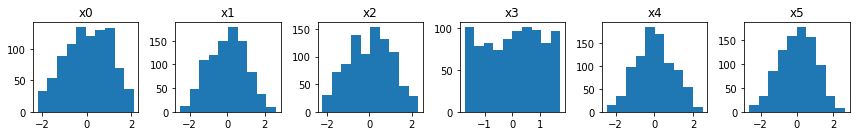

In [5]:
fig, axes = plt.subplots(1, X.shape[1], figsize=(12, 2))
for i, (ax, x) in enumerate(zip(axes, X.T)):
    ax.hist(x)
    ax.set_title(f"x{i}")
plt.tight_layout()
plt.show()

### The causal discovery with the multiple imputation

`bootstrap_with_imputation` creates bootstrap samples and performs the multiple imputation on each bootstrap samples and estimates adjacency matricies for each imputed datasets.

The following codes replaces the implement of the multiple imputation and the implement of the causal discovery algorithm for the multigroup dataset.

In [6]:
class CustomizedMultipleImputation(BaseMultipleImputation):
    """ perform the multiple imputation by mice"""
    
    def __init__(self, is_discrete=None):
        self._is_discrete = is_discrete
    
    def fit_transform(self, X):
        X_ = impute_by_mice(X, is_discrete=self._is_discrete)
        return X_


class CustomizedMGCDModel(BaseMultiGroupCDModel):
    """ perform the causal discovery on the multigroup dataset and
        prune estimated adjacency matrices assuming a common pruning pattern. 
    """
    
    def __init__(self, ad_weight_type="min", prior_knowledge=None, apply_prior_knowledge_softly=False, random_state=None):
        self._model = MultiGroupDirectLiNGAM(
            prior_knowledge=prior_knowledge,
            apply_prior_knowledge_softly=apply_prior_knowledge_softly,
            random_state=random_state
        )

        self._ad_weight_type = ad_weight_type
        self._random_state = random_state
        
        self._weights = None

    def before_imputation(self, X):
        self._weights = 1 - np.sum(np.isnan(X), axis=1) / X.shape[1]

    def fit(self, X_list):
        self._model.fit(X_list)
        causal_order = self._model.causal_order_
        
        seed = None
        if self._random_state != None:
            seed = random_state.randint(0, 1e+4)
        
        adj_mat = estimate_adj_matrix_for_stacked_imputed_datasets(
            X_list,
            causal_order,
            ad_weight_type=self._ad_weight_type,
            weights=self._weights,
            seed=seed
        )

        return causal_order, adj_mat

# create instances for multiple imputation and causal discovery
imp = CustomizedMultipleImputation()
cd_model = CustomizedMGCDModel()

# number of bootstraps
n_sampling = 3

# send instances
result = bootstrap_with_imputation(X, n_sampling, imp=imp, cd_model=cd_model)

causal_orders, adj_list, resampled_indices, imputation_results = result

The followings are estimated causal orders and adjacency matrices.

In [7]:
causal_orders

array([[3, 2, 0, 4, 1, 5],
       [3, 0, 2, 4, 1, 5],
       [3, 0, 2, 1, 5, 4]])

In [8]:
for adj in adj_list:
    display(pd.DataFrame(adj).style.background_gradient(axis=None))

,0,1,2,3,4,5
0,0.000000,0.000000,-0.003025,0.850140,0.000000,0.000000
1,0.452663,0.000000,0.408482,0.000000,0.049828,0.000000
2,0.000000,0.000000,0.000000,0.879022,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.882349,0.000000,-0.047575,0.000000,0.000000,0.000000
5,0.702367,0.100703,0.000000,0.039378,0.000000,0.000000


,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.860852,0.000000,0.000000
1,0.470654,0.000000,0.454914,0.000000,0.020468,0.000000
2,0.000000,0.000000,0.000000,0.905771,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.912643,0.000000,-0.069722,0.000000,0.000000,0.000000
5,0.775150,0.072732,0.003812,0.016308,0.000000,0.000000


,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.828359,0.000000,0.000000
1,0.539892,0.000000,0.435348,0.000000,0.000000,0.000000
2,-0.024177,0.000000,0.000000,0.917001,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.896720,0.000000,-0.054074,0.000000,0.000000,0.000000
5,0.831664,0.000000,0.038242,0.000000,0.000000,0.000000


## Dataset where all variables are continuous except one

Under the assumption that the discrete variable in a dataset is the only exogenous variable in the dataset, it is possible to support datasets that include a discrete variable.

### Test data

In [9]:
def generate_data_d(disc_index=3, size=1000):
    scales = [0.2, 0.2, 0.2, 1, 0.2, 0.2]
    e = np.array([np.random.uniform(-np.sqrt(3 * s), np.sqrt(3 * s), size=size) for s in scales])

    X = np.zeros((size, len(true_m)))
    for co in true_causal_order:
        if co == disc_index:
            X[:, co] = true_m[co, :] @ X.T + e[co, :]

            r_prob = np.random.uniform(low=0.0, high=1.0, size=size)
            X[:, co] = np.where(r_prob < X[:, co], 1, 0)
        else:
            X[:, co] = true_m[co, :] @ X.T + e[co, :]

    return X

X = generate_data_d()
is_discrete = [False, False, False, True, False, False]

prop_missing = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
missing_pos = generate_missing_pos(prop_missing)

# keep true values
true_values = X.copy()
true_values[~missing_pos] = np.nan

X[missing_pos] = np.nan

Actual proportions of missing values are as follows:

In [10]:
np.isnan(X).sum(axis=0) / len(X)

array([0.113, 0.101, 0.095, 0.099, 0.086, 0.101])

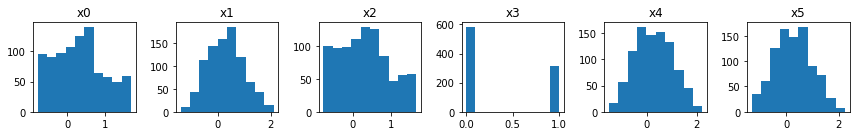

In [11]:
fig, axes = plt.subplots(1, X.shape[1], figsize=(12, 2))
for i, (ax, x) in enumerate(zip(axes, X.T)):
    ax.hist(x)
    ax.set_title(f"x{i}")
plt.tight_layout()
plt.show()

## Estimate adjacency matrix

In [12]:
class CustomizedMGCDModelDiscrete(BaseMultiGroupCDModel):
    
    def __init__(self, is_discrete=None, ad_weight_type="min", prior_knowledge=None, apply_prior_knowledge_softly=False, random_state=None):
        
        if np.sum(is_discrete) != 1:
            raise ValueError
        
        self._model = MultiGroupDirectLiNGAM(
            prior_knowledge=prior_knowledge,
            apply_prior_knowledge_softly=apply_prior_knowledge_softly,
            random_state=random_state
        )
        
        self._is_discrete = is_discrete
        self._ad_weight_type = ad_weight_type
        self._weights = None

    def before_imputation(self, X):
        # calc weights by ratio of missing values
        self._weights = 1 - np.sum(np.isnan(X), axis=1) / X.shape[1]

    def fit(self, X_list):
        # index of the discrete variable
        d_index = np.argwhere(is_discrete)[0][0]
        
        # remove effects of the discrete variable and delete the discrete variable
        X_list_ = []
        for X in X_list:
            X_ = np.zeros(X.shape)
            
            for c_index in range(X.shape[1]):
                if c_index == d_index:
                    continue

                model = LinearRegression()
                model.fit(X[:, [d_index]], X[:, [c_index]])
                
                X_[:, [c_index]] = X[:, [c_index]] - model.predict(X[:, [d_index]])
            X_ = np.delete(X_, d_index, axis=1)
            X_list_.append(X_)
        
        # perform causal discovery
        self._model.fit(X_list_)
        causal_order = self._model.causal_order_

        # add removed discrete variable to estimated causal_order
        for i, c in enumerate(causal_order):
            if c < d_index:
                continue
            causal_order[i] += 1
        causal_order = [d_index, *causal_order]
        
        # prune adjacency matrix
        adj_mat = estimate_adj_matrix_for_stacked_imputed_datasets(
            X_list,
            causal_order,
            is_discrete=self._is_discrete,
            ad_weight_type=self._ad_weight_type,
            weights=self._weights,
            seed=np.random.randint(0, 1e+4)
        )

        return causal_order, adj_mat

imp = CustomizedMultipleImputation(is_discrete=is_discrete)
cd_model = CustomizedMGCDModelDiscrete(is_discrete=is_discrete)

n_sampling = 3

result = bootstrap_with_imputation(X, n_sampling, imp=imp, cd_model=cd_model)

causal_orders, adj_list, resampled_indices, imputation_results = result

In [13]:
causal_orders

array([[3, 0, 5, 2, 1, 4],
       [3, 0, 5, 2, 1, 4],
       [3, 0, 2, 1, 5, 4]])

In [14]:
adj_list

array([[[ 0.   ,  0.   ,  0.   ,  0.92 ,  0.   ,  0.   ],
        [ 0.48 ,  0.   ,  0.38 ,  0.009,  0.   ,  0.05 ],
        [ 0.   ,  0.   ,  0.   ,  0.889,  0.   ,  0.006],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 1.064, -0.016, -0.173,  0.   ,  0.   , -0.016],
        [ 0.843,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.92 ,  0.   ,  0.   ],
        [ 0.513,  0.   ,  0.324,  0.   ,  0.   ,  0.022],
        [ 0.   ,  0.   ,  0.   ,  0.93 ,  0.   , -0.001],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 1.008,  0.027, -0.191,  0.   ,  0.   ,  0.   ],
        [ 0.777,  0.   ,  0.   ,  0.002,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   ,  0.952,  0.   ,  0.   ],
        [ 0.559,  0.   ,  0.381, -0.046,  0.   ,  0.   ],
        [-0.016,  0.   ,  0.   ,  0.996,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.976,  0.023, -0.127,  0.   ,  0.   ,  0.   ],
        [ 